In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2023-03-10 05:07:43--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2023-03-10 05:07:43--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04f0c6876cf939d3abf8c1e5c1.dl.dropboxusercontent.com/cd/0/inline/B38AchrYMy0cADJaGZspDv89Hgr8SZ3Tbqk8iWf7wEY1p5BJtTztB-Sveb68pc-vnmAoAHm3AISRpi8mGo0r8FB7lF1NzT4glhbIDnT8GuKZR0T1XdKWcWJjiAaGNyak_QvOxiEWdzN7dZ1khUeoZFn965B5Frd_vY1g8Z0TxmfoQg/file# [following]
--2023-03-10 05:07:44--  https://uc04f0c6876cf939d3abf8c1e5c1.dl.dropboxusercontent.com/cd/0/inline/B38AchrYMy0cADJaGZspDv89Hgr8SZ3Tbqk8iWf7wEY1p5BJtTztB-Sveb68pc-vnmAoAHm3AISRpi8mGo0

In [4]:
!unzip -q 'archive.zip'

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [6]:
train_path = Path("chest_xray/train/")
test_path = Path("chest_xray/test/")
validation_path = Path("chest_xray/val/")

In [7]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
validation_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7f389cdf1f50>


In [8]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
validation_image_paths = list(validation_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/PNEUMONIA/person336_bacteria_1548.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person442_virus_903.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person1140_virus_1885.jpeg')]


In [9]:
# Convert Posix paths to normal strings

train_image_paths = [str(i) for i in train_image_paths]
validation_image_paths = [str(i) for i in validation_image_paths]

print(train_image_paths[:3])

['chest_xray/train/PNEUMONIA/person336_bacteria_1548.jpeg', 'chest_xray/train/PNEUMONIA/person442_virus_903.jpeg', 'chest_xray/train/PNEUMONIA/person1140_virus_1885.jpeg']


In [10]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
validation_dataset_length = len(validation_image_paths)

In [11]:
# Every Image has Label in its path , so lets slice it 

train_labels = []
validation_labels = []

for i in train_image_paths:
  if i.split('/')[-2] == 'NORMAL':
    train_labels.append(0)
  elif i.split('/')[-2] == 'PNEUMONIA':
    train_labels.append(1)

for i in validation_image_paths:
  if i.split('/')[-2] == 'NORMAL':
    validation_labels.append(0)
  elif i.split('/')[-2] == 'PNEUMONIA':
    validation_labels.append(1)


# Now we have all training, validation image paths and their respective labels 

In [12]:
# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

In [13]:
# Function used to Create a Tensorflow Data Object
BATCH_SIZE = 32

def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [14]:
# Creating Train Dataset object and Verifying it
train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


In [15]:
type(image)

tensorflow.python.framework.ops.EagerTensor

PNEUMONIA


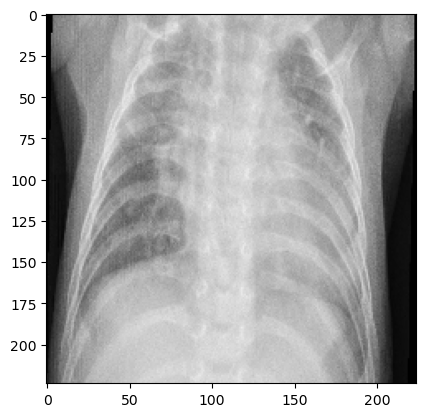

In [16]:
# View a sample Train Image
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [17]:
validation_dataset = get_dataset(validation_image_paths , validation_labels , train = False)

image , label = next(iter(validation_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


PNEUMONIA


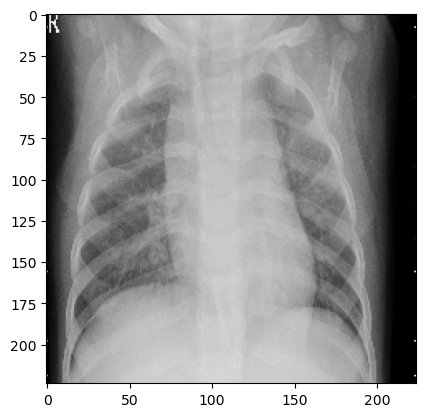

In [18]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [23]:
# Building ResNet50 model

from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(input_shape=(224, 224, 3), include_top=False)

model = tf.keras.Sequential()
model.add(ResNet50V2(input_shape=(224, 224, 3), include_top=False))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,827,201
Trainable params: 23,781,761
Non-trainable params: 45,440
_____________________________________

In [24]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [25]:
# Defining our callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [26]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=10,
    callbacks=[early_stop],
    validation_data=validation_dataset,
    validation_steps = validation_dataset_length//BATCH_SIZE,
)

Epoch 1/10
163/163 [==============================] - 94s 343ms/step - loss: 0.2206 - accuracy: 0.8020 - precision: 0.8020 - recall: 1.0000
Epoch 2/10
163/163 [==============================] - 55s 340ms/step - loss: 0.1542 - accuracy: 0.7492 - precision: 0.7492 - recall: 1.0000
Epoch 3/10
163/163 [==============================] - 55s 338ms/step - loss: 0.1117 - accuracy: 0.7475 - precision: 0.7475 - recall: 1.0000
Epoch 4/10
163/163 [==============================] - 54s 332ms/step - loss: 0.0831 - accuracy: 0.7444 - precision: 0.7444 - recall: 1.0000
Epoch 5/10
163/163 [==============================] - 52s 320ms/step - loss: 0.1909 - accuracy: 0.7446 - precision: 0.7446 - recall: 1.0000
Epoch 6/10
163/163 [==============================] - 51s 310ms/step - loss: 0.1203 - accuracy: 0.7356 - precision: 0.7356 - recall: 1.0000
Epoch 7/10
163/163 [==============================] - 51s 311ms/step - loss: 0.0957 - accuracy: 0.7450 - precision: 0.7450 - recall: 1.0000
Epoch 8/10
163/163 [

In [41]:

# Save the whole model (weigths + architecture)
model.save("model.h5")

In [42]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

In [31]:
# Getting the path of the test folder
test_path = Path("chest_xray/test/")
# getting all the files path location from the test path
test_image_paths = test_path.glob("*/*")
# converting the received object to list type
test_image_paths = list(test_image_paths)
# now inside list, converting each object to string type
test_image_paths = [str(i) for i in test_image_paths]
# getting the length of the dataset which has all the paths
test_dataset_length = len(test_image_paths)

# Every Image has Label in its path , so lets slice it 
test_labels = []

for i in test_image_paths:
  if i.split('/')[-2] == 'NORMAL':
    test_labels.append(0)
  elif i.split('/')[-2] == 'PNEUMONIA':
    test_labels.append(1)


# Now we have all training, validation image paths and their respective labels

In [32]:
# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

In [36]:
# Function used to Create a Tensorflow Data Object


def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.batch(16)

    return dataset

In [37]:
# Creating Train Dataset object and Verifying it
test_dataset = get_dataset(test_image_paths , test_labels)

image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


PNEUMONIA


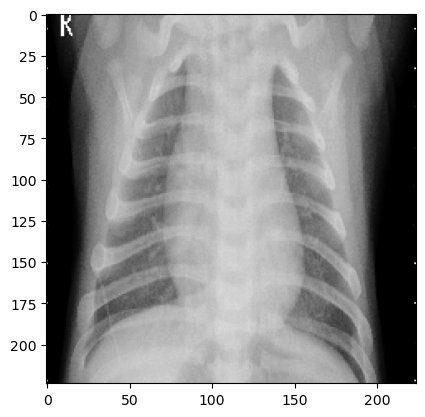

In [38]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [43]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

39/39 [==============================] - 5s 79ms/step - loss: 3.8542 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
 Testing Acc :  0.625
 Testing Precision  0.625
 Testing Recall  1.0
